# Run network model

In [19]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.models.catdata import *
from src.models.catmodel import *
from src.data.utils import get_tile_prefix
from src.models.metrics_img import auc_roc
#import rasterio.plot as rioplot
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg

from pathlib import Path
import os, shutil
import sys
%matplotlib inline

import pandas as pd

import math

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from keras import backend as keras

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## User settings

### Define and make (if necessary) train/validation/test directories

In [20]:
df = pd.read_csv('../visualize_imagery/numOfPixPerClassPerTile_256.csv')
df = df.drop(['Unnamed: 0'], axis = 1)

In [21]:
sdf = df[((df['relative_noRoad']) < 0.95) 
         & ((df['relative_pavedRoad']) > 0.0)
        ].\
        reset_index(drop=True)
sdf = shuffle(sdf)
#sdf, _  = train_test_split(sdf, test_size=0.9)
print(len(sdf))
train_tmp, test = train_test_split(sdf, test_size=0.2)
train, valid = train_test_split(train_tmp, test_size=0.2)

937


In [22]:
print(test.region.value_counts())
print("")
print(valid.region.value_counts())
print("")
print(train.region.value_counts())

#test = test[(test['region'] == 'Borneo')]

Harz      180
Borneo      8
Name: region, dtype: int64

Harz      145
Borneo      5
Name: region, dtype: int64

Harz      570
Borneo     29
Name: region, dtype: int64


In [23]:
sdf.numPixel_unpavedRoad.median(), sdf.numPixel_pavedRoad.median()

(2210.0, 2737.0)

In [24]:
sdf.relative_unpavedRoad.mean(), sdf.relative_pavedRoad.mean()

(0.03471016247727955, 0.05820008301302361)

In [25]:
sdf.numPixel_pavedRoad.sum(), sdf.numPixel_unpavedRoad.sum()

(3573906, 2131455)

In [26]:
def create_class_weight(labels_dict,mu=0.25):
    total = sum(labels_dict.values())
    print(total)
    keys = labels_dict.keys()
    class_weight = dict()
    weights = []
    for key in keys:
        score = math.log(mu*total/float(labels_dict[key]))
        class_weight[key] = score if score > 1.0 else 1.0
        weights.append(score if score > 1.0 else 1.0)

    return weights#class_weight

In [27]:
labeldict = {
    0: train.numPixel_noRoad.mean(),
    1: train.numPixel_pavedRoad.mean(),
    2: train.numPixel_unpavedRoad.mean()
}

create_class_weight(labeldict)

65536.0


[1.0, 1.4568947106978547, 1.9690278358143498]

In [28]:
def nl_loss(y_true, y_pred):
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
    return -K.sum(y_true * K.log(y_pred), axis=-1)

def categoricalCrossentropy(y_true, y_pred, the0, the1):
    '''
    Calculate the class-weighted categorical cross-entropy for the given
    predicted and true sets.

    y_true [in] The truth set to test against. This is a Tensor with a last
                dimension that contains a set of 1-of-N selections.
    y_pred [in] The predicted set to test against. This is a Tensor with a last
                dimension that contains a set of 1-of-N selections.
    returns     A Tensor function that will calculate the weighted categorical
                cross-entropy on the inputs.
    '''

    P = np.array([[1, the1, the1], 
                  [the0, 1, the1], 
                  [the1, the0, 1]])
    P = np.array([[1, 0, 0], 
                  [0, 1, the0], 
                  [the1, 0, 1]])
    P = P#/np.linalg.norm(P)

    P_inv = K.constant(np.linalg.inv(P))
    # If weights are defined, multiply the truth values by the class weights.
    #
    if P_inv is not None:
        # Wrap the loss weights in a tensor object.
        #
        pp =  np.linalg.inv(P)
        theWeights =  K.constant(pp, shape=pp.shape)

        y_true = K.dot(y_true,theWeights)

    # Get the cross-entropy and return it.
    #
    crossEntropy =K.categorical_crossentropy(y_true, y_pred)

    return crossEntropy

def dice_loss(the0, the1):    
    def loss(y_true, y_pred):
        return categoricalCrossentropy(y_true, y_pred, the0, the1)
    return loss
    
def pixel_wise_loss(y_true, y_pred):
    pos_weight = tf.constant(P_inv)
    loss = tf.nn.weighted_cross_entropy_with_logits(
        y_true,
        y_pred,
        pos_weight,
        name=None
    )

    return K.mean(loss,axis=-1)

In [29]:
original_dataset_dir = "../../data/train_raw"
raw_images_path = "../../data/raw/images"
dirs = []

base_dir = "../../data"

train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
test_dir = os.path.join(base_dir, "test")
dirs.append(test_dir)

In [30]:
for directory in dirs:
    if not os.path.exists(directory):
        os.mkdir(directory)

In [37]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")

# ------------- image characteristics and augmentation -----------------------------
# size of tiles
target_size = (256, 256)
# input arguments to Keras' ImageDataGenerator
data_gen_args = dict(
    data_format="channels_last",
    horizontal_flip=True,
    vertical_flip=True
 )
# if True, image tiles will be split up into training/validation/test sets
# only required after a fresh 'make data'
do_data_split = True
# directory into which to place *training* images from ImageDataGenerator for inspection;
# default should be None because this slows things down
imgdatagen_dir = None
#imgdatagen_dir = '../../data/imgdatagenerator'

#--------------- network weights ----------------------------------------------------
# path to & filename of pre-trained model to use - set to None if you want to start from scratch
# pretrained_model_fn = "../../models/unet_membrane_analytic_27_08_14_55.hdf5"
pretrained_model_fn = False
#pretrained_model_fn = '../../models/0904_0148_NL_Borneo_multiCat_unet.hdf5'

# path to & filename of model to save
trained_model_fn = '../../models/0905_1500_NL_multiCat_unet.hdf5'

#--------------- training details / hyperparameters -----------------------------------
# batch size
batch_size = 3
# steps per epoch, should correspond to [number of training images] / batch size
steps_per_epoch = len(train) * batch_size
# number of epochs
epochs = 15
# number of steps on validation set
validation_steps = len(valid) * batch_size
# self-explanatory variables:
optimizer    = Adam(lr=1e-4)
#loss         = categoricalCrossentropy#'categorical_crossentropy'
loss_weights = None
metrics      = ['accuracy', auc_roc]

### Split data up into train/validation/test images

In [38]:
if do_data_split:
    def should_make_tiles_from(r_analytic_name):
        is_analytic_tif = r_analytic_name.endswith(
            ('AnalyticMS.tif', 'AnalyticMS_SR.tif', 'AnalyticMS.tiff', 'AnalyticMS_SR.tiff')
        )
        return is_analytic_tif 

    file_prefixes = [ get_tile_prefix(r_analytic.name) 
                      for r_analytic in Path(raw_images_path).iterdir()  
                        if  should_make_tiles_from(r_analytic.name)
                    ]
    print(file_prefixes)
                
    # copy files to train dir
    train_fnames = train.name.values
    for fname in train_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(original_dataset_dir, file_type, fname)
            dest = os.path.join(train_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.copy(src, dest)

    # copy files to validation dir
    validation_fnames = valid.name.values
    for fname in validation_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            print(fname)
            src = os.path.join(original_dataset_dir, file_type, fname)
            dest = os.path.join(validation_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.copy(src, dest)
    # copy files to test dir
    test_fnames = test.name.values
    for fname in test_fnames:
        for file_type in ["sat", "map", "sat_rgb"]:
            src = os.path.join(original_dataset_dir, file_type, fname)
            dest = os.path.join(test_dir, file_type, fname)
            if(os.path.exists(src)):
                shutil.copy(src, dest)
                
    # print overview
    for directory in dirs:
        for file_type in ["sat", "map", "sat_rgb"]:
            target = os.path.join(directory, file_type)
            print(target, ":", len(os.listdir(target)))

    print("Done.")

['20170815_005028_0c0b_3B', '20180419_074326_0c43_3B', '20180427_020346_103a_3B', '20180504_094435_0e19_3B', '20180419_074323_0c43_3B', '20180427_020502_103c_3B', '20180427_020347_103a_3B', '20171013_232848_0c46_3B', '20180427_020501_103c_3B', '20180310_020203_1040_3B', '20180419_074324_0c43_3B', '20170815_005030_0c0b_3B', '20180419_074325_0c43_3B', '20180310_020202_1040_3B', '20180427_020504_103c_3B', '20180606_020625_0f1b_3B', '20180419_074324_1_0c43_3B', '20180724_094554_0e19_3B', '20170920_015736_0f28_3B', '20180427_020503_103c_3B']
20180419_074325_0c43_3B_0071.tif
20180419_074325_0c43_3B_0071.tif
20180419_074325_0c43_3B_0071.tif
20180419_074324_0c43_3B_0271.tif
20180419_074324_0c43_3B_0271.tif
20180419_074324_0c43_3B_0271.tif
20180724_094554_0e19_3B_0618.tif
20180724_094554_0e19_3B_0618.tif
20180724_094554_0e19_3B_0618.tif
20180419_074325_0c43_3B_0320.tif
20180419_074325_0c43_3B_0320.tif
20180419_074325_0c43_3B_0320.tif
20180419_074324_1_0c43_3B_0197.tif
20180419_074324_1_0c43_3B_

20180419_074323_0c43_3B_0104.tif
20180419_074323_0c43_3B_0104.tif
20180419_074323_0c43_3B_0104.tif
20180504_094435_0e19_3B_0240.tif
20180504_094435_0e19_3B_0240.tif
20180504_094435_0e19_3B_0240.tif
20180419_074324_0c43_3B_0278.tif
20180419_074324_0c43_3B_0278.tif
20180419_074324_0c43_3B_0278.tif
20180419_074326_0c43_3B_0185.tif
20180419_074326_0c43_3B_0185.tif
20180419_074326_0c43_3B_0185.tif
20180419_074325_0c43_3B_0019.tif
20180419_074325_0c43_3B_0019.tif
20180419_074325_0c43_3B_0019.tif
20180419_074324_0c43_3B_0246.tif
20180419_074324_0c43_3B_0246.tif
20180419_074324_0c43_3B_0246.tif
20180419_074326_0c43_3B_0107.tif
20180419_074326_0c43_3B_0107.tif
20180419_074326_0c43_3B_0107.tif
20180504_094435_0e19_3B_0117.tif
20180504_094435_0e19_3B_0117.tif
20180504_094435_0e19_3B_0117.tif
20180504_094435_0e19_3B_0624.tif
20180504_094435_0e19_3B_0624.tif
20180504_094435_0e19_3B_0624.tif
20180419_074324_1_0c43_3B_0297.tif
20180419_074324_1_0c43_3B_0297.tif
20180419_074324_1_0c43_3B_0297.tif
2018

### Set up ImageDataGenerators for training and validation sets

In [39]:
train_gen = trainGenerator(
    batch_size,'../../data/train','sat','map',
    data_gen_args,
    save_to_dir = imgdatagen_dir,
    image_color_mode="rgba",
    target_size=target_size,
    flag_multi_class=True,
    num_class=3
)

validation_gen = trainGenerator(
    batch_size,'../../data/validate','sat','map',
    data_gen_args, 
    save_to_dir = None, 
    image_color_mode="rgba", 
    target_size=target_size, 
    flag_multi_class=True,
    num_class=3
)

### Define model, compile, show summary, possibly load weights, define callbacks (including checkpoints)

In [40]:
le = next(train_gen)
print(len(le), (le[1][0][..., 1]))
print('nonzero', np.sum(le[1][0][..., 1] != 0))

Found 827 images belonging to 1 classes.
Found 827 images belonging to 1 classes.
2 [[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
nonzero 3133


In [41]:
print(np.shape(le[1][1]))

(256, 256, 3)


In [42]:
model = unet((256, 256, 4), 3)
model.compile(optimizer=optimizer,
              loss=dice_loss(0.01, 0.08),
              loss_weights=loss_weights,
              metrics=metrics)
model.summary()
if (pretrained_model_fn):
    model.load_weights(pretrained_model_fn)
model_checkpoint = ModelCheckpoint(trained_model_fn, monitor='loss',verbose=1, save_best_only=True)


/home/ubuntu/roaddetection/src/models/catmodel.py:56: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(3, (1, 1), padding="same", activation="relu")`
  conv10 = layers.Conv2D(nClasses, 1, 1, activation='relu',border_mode='same')(conv9)
/home/ubuntu/roaddetection/src/models/catmodel.py:63: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=Tensor("in...)`
  model = Model(input=inputs, output=conv10)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 256, 256, 4)  0                                            
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 256, 256, 64) 2368        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_49[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_9 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_50[0][0]                  
__________________________________________________________________________________________________
conv2d_51 

### Run training

In [43]:
class_weights = create_class_weight(labeldict)
#{0: 1., 1: 25., 2: 75.}
#the1 = 0.8, the0 = 0.1

history = model.fit_generator(
    train_gen,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    class_weight=class_weights,
    callbacks=[model_checkpoint],
    validation_data=validation_gen,
    validation_steps=validation_steps
)

65536.0
Epoch 1/15
Found 284 images belonging to 1 classes.
Found 284 images belonging to 1 classes.
1797/1797 [==============================] - 418s 232ms/step - loss: 1.0459 - acc: 0.9051 - auc_roc: 0.9175 - val_loss: 0.9975 - val_acc: 0.9038 - val_auc_roc: 0.9281

Epoch 00001: loss improved from inf to 1.04594, saving model to ../../models/0905_1500_NL_multiCat_unet.hdf5
Epoch 2/15
1797/1797 [==============================] - 410s 228ms/step - loss: 0.9522 - acc: 0.9062 - auc_roc: 0.9285 - val_loss: 0.9093 - val_acc: 0.9041 - val_auc_roc: 0.9288

Epoch 00002: loss improved from 1.04594 to 0.95224, saving model to ../../models/0905_1500_NL_multiCat_unet.hdf5
Epoch 3/15
1797/1797 [==============================] - 409s 228ms/step - loss: 0.8679 - acc: 0.9062 - auc_roc: 0.9289 - val_loss: 0.8294 - val_acc: 0.9042 - val_auc_roc: 0.9290

Epoch 00003: loss improved from 0.95224 to 0.86792, saving model to ../../models/0905_1500_NL_multiCat_unet.hdf5
Epoch 4/15
1797/1797 [================

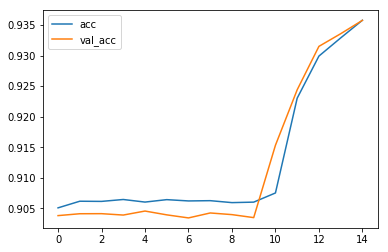

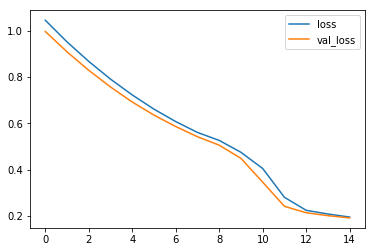

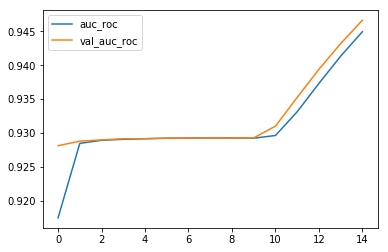

In [44]:
import matplotlib.pyplot as plt

def plot_history(history):
    plt.plot(history["acc"], label="acc")
    plt.plot(history["val_acc"], label="val_acc")
    plt.legend()
    plt.show()
    plt.close()
    
    plt.plot(history["loss"], label="loss")
    plt.plot(history["val_loss"], label="val_loss")
    plt.legend()
    plt.show()
    plt.close()

    plt.plot(history["auc_roc"], label="auc_roc")
    plt.plot(history["val_auc_roc"], label="val_auc_roc")
    plt.legend()
    plt.show()
    plt.close()

plot_history(history.history)

In [45]:
testGene = testGenerator("../../data/test/sat",target_size=(256, 256),as_gray=False)
n = 0
for img, name in testGene:
    results = model.predict(img, batch_size=1)
    saveResult("../../data/test/predict", results, name, True, 3)
    n += 1
    if(n>300):
        break

/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180419_074326_0c43_3B_0077.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180724_094554_0e19_3B_0021.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180419_074326_0c43_3B_0200.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/ubuntu/.local/lib/python3.5/site-packages/skimage/io/_io.py:140: UserWarning: ../../data/test/predict/20180419_074323_0c43_3B_0285.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
